In [1]:
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


BASE_PATH = "/kaggle/input/skin-cancer-mnist-ham10000"

IMG_DIR_1 = os.path.join(BASE_PATH, "HAM10000_images_part_1")
IMG_DIR_2 = os.path.join(BASE_PATH, "HAM10000_images_part_2")

META_CSV = os.path.join(BASE_PATH, "HAM10000_metadata.csv")
OUTPUT_DIR = "/kaggle/working/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

2025-11-17 07:33:37.739529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763364817.973766      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763364818.041815      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv(META_CSV)
print(df.head())
print(df.shape)

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
(10015, 7)


In [4]:
print("Columns:", df.columns)
print("\nMissing values:")
print(df.isna().sum())

print("\nData types:")
print(df.dtypes)

Columns: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

Missing values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Data types:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object


In [5]:
def get_image_path(image_id):
    fname = image_id + ".jpg"
    p1 = os.path.join(IMG_DIR_1, fname)
    p2 = os.path.join(IMG_DIR_2, fname)
    return p1 if os.path.exists(p1) else p2

df["img_path"] = df["image_id"].apply(get_image_path)
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                            img_path  
0  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
1  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
2  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
3  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  
4  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...

In [6]:
df["img_path"].isna().sum()   # should be 0

0

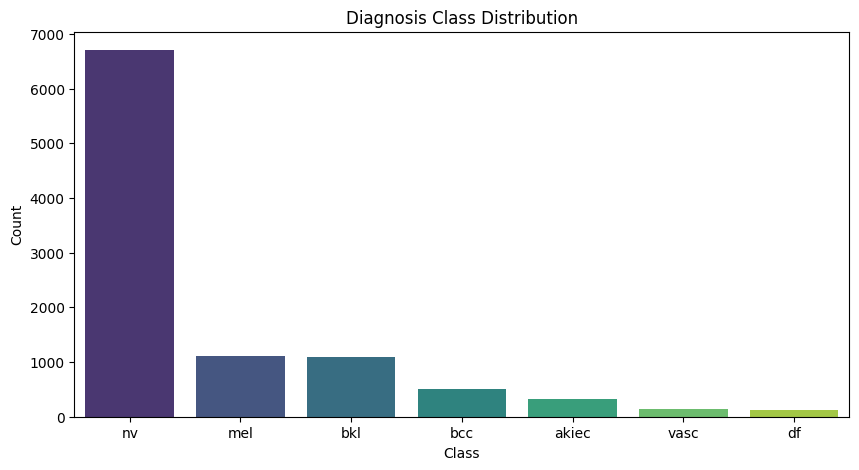

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [7]:
plt.figure(figsize=(10,5))
class_counts = df["dx"].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Diagnosis Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

class_counts

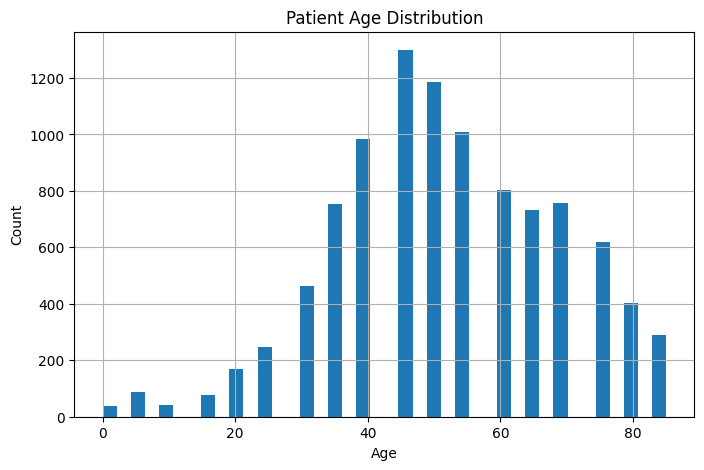

In [8]:
plt.figure(figsize=(8,5))
df["age"].hist(bins=40)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

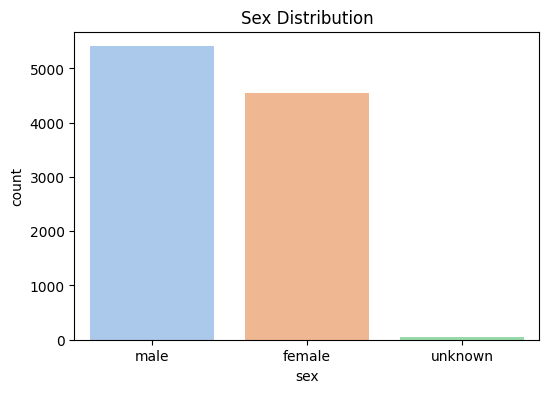

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sex", palette="pastel")
plt.title("Sex Distribution")
plt.show()

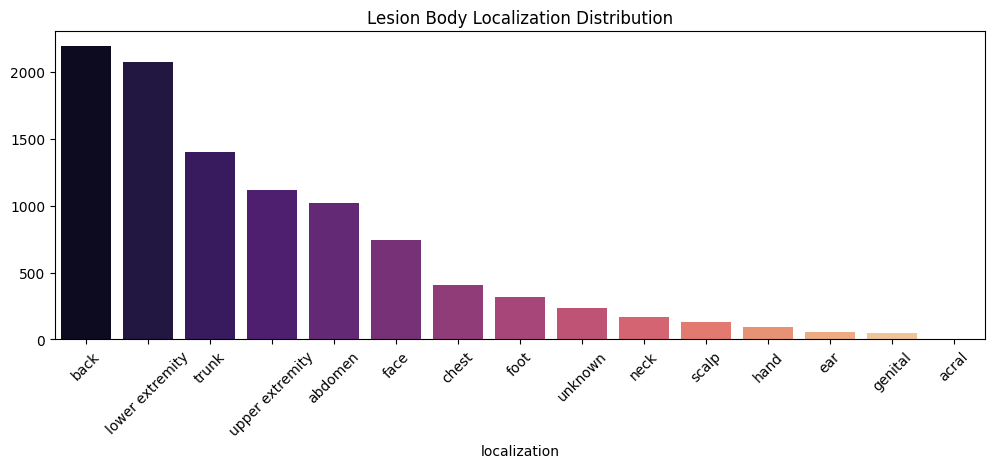

In [10]:
plt.figure(figsize=(12,4))
loc_counts = df["localization"].value_counts()
sns.barplot(x=loc_counts.index, y=loc_counts.values, palette="magma")
plt.xticks(rotation=45)
plt.title("Lesion Body Localization Distribution")
plt.show()

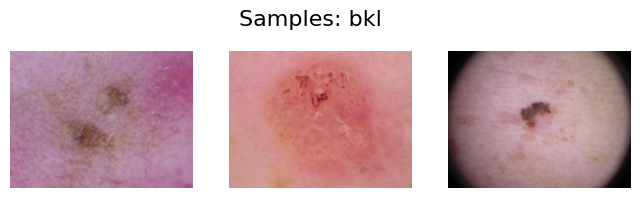

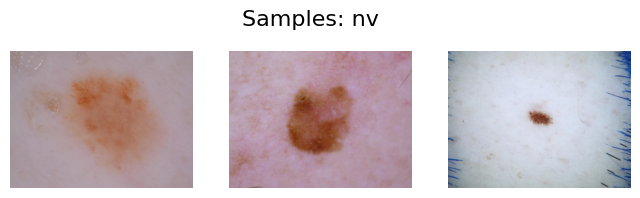

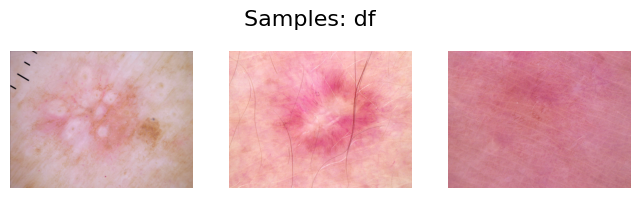

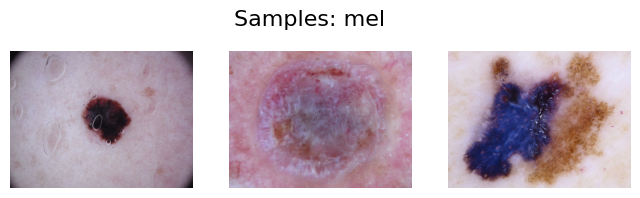

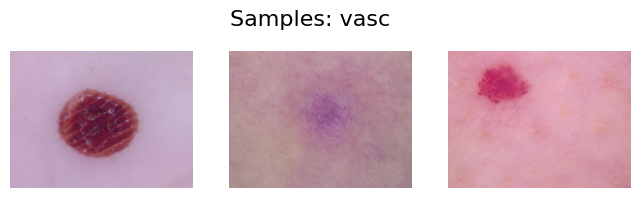

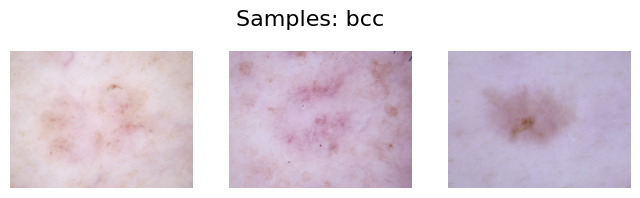

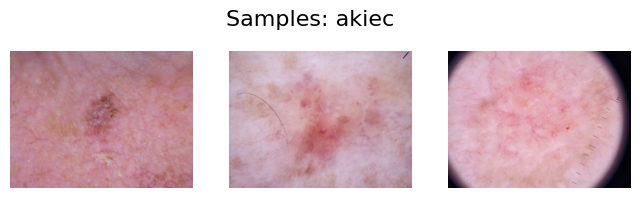

In [11]:
def show_samples(label, n=3):
    subset = df[df["dx"] == label].sample(n)
    plt.figure(figsize=(8,4))
    plt.suptitle(f"Samples: {label}", fontsize=16)

    for i, row in enumerate(subset.itertuples()):
        img = plt.imread(row.img_path)
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()

for label in df["dx"].unique():
    show_samples(label)

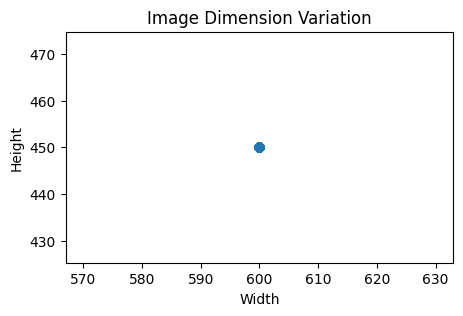

Mean size: [600. 450.]
Common sizes: (600, 450)    300
Name: count, dtype: int64


In [12]:
sizes = []
for p in df["img_path"].sample(300):  # sample for speed
    img = Image.open(p)
    sizes.append(img.size)

sizes = np.array(sizes)
plt.figure(figsize=(5,3))
plt.scatter(sizes[:,0], sizes[:,1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Dimension Variation")
plt.show()

print("Mean size:", sizes.mean(axis=0))
print("Common sizes:", pd.Series(list(zip(sizes[:,0], sizes[:,1]))).value_counts().head())

In [13]:
# Choices
TARGET_SIZE = (224, 224)   # for ResNet50
BATCH_SIZE = 32
IMG_CHANNELS = 3
EPOCHS_STAGE1 = 6
EPOCHS_STAGE2 = 10

print("Config ready. TARGET_SIZE:", TARGET_SIZE)

Config ready. TARGET_SIZE: (224, 224)


In [14]:
# Load metadata and attach file paths
df = pd.read_csv(META_CSV)
print("Initial rows:", df.shape)

def get_image_path(image_id):
    fname = image_id + ".jpg"
    p1 = os.path.join(IMG_DIR_1, fname)
    p2 = os.path.join(IMG_DIR_2, fname)
    if os.path.exists(p1):
        return p1
    elif os.path.exists(p2):
        return p2
    else:
        return None

df['img_path'] = df['image_id'].apply(get_image_path)
missing = df['img_path'].isna().sum()
print("Missing image paths:", missing)
df = df.dropna(subset=['img_path']).reset_index(drop=True)
print("After dropna:", df.shape)

Initial rows: (10015, 7)
Missing image paths: 0
After dropna: (10015, 8)


In [15]:
# Label encoding (map dx to integers)
dx_unique = sorted(df['dx'].unique().tolist())
label_map = {k:i for i,k in enumerate(dx_unique)}
inv_label_map = {v:k for k,v in label_map.items()}
print("Label map:", label_map)

df['label'] = df['dx'].map(label_map)
df[['image_id','dx','label']].head()

Label map: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


image_id   dx  label
0  ISIC_0027419  bkl      2
1  ISIC_0025030  bkl      2
2  ISIC_0026769  bkl      2
3  ISIC_0025661  bkl      2
4  ISIC_0031633  bkl      2

In [16]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# Step 4: Stratified train/val split (80/20)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)
print("Train:", train_df.shape, "Val:", val_df.shape)

# Optionally save CSVs for reproducibility
train_df.to_csv("/kaggle/working/train_df.csv", index=False)
val_df.to_csv("/kaggle/working/val_df.csv", index=False)

Train: (8012, 9) Val: (2003, 9)


In [17]:
# UNIVERSAL GENERATOR (use for all models)
def get_generators(train_df, val_df, target_size=(224,224), batch_size=32, preprocess_fn=None, seed=42):

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        brightness_range=[0.85, 1.15],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn
    )

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='img_path',
        y_col='dx',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )

    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='img_path',
        y_col='dx',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen

In [18]:
from collections import Counter

train_counts = Counter(train_df['dx'])
total = sum(train_counts.values())
num_classes = len(train_counts)

class_weights = {
    i: total/(num_classes * count)
    for i, count in enumerate(train_counts.values())
}

print("Class weights:", class_weights)

Class weights: {0: 0.21338020666879728, 1: 4.368593238822246, 2: 1.3021290427433772, 3: 2.7848453249913105, 4: 1.2860353130016051, 5: 10.040100250626567, 6: 12.440993788819876}


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['dx'])
val_df['label_enc'] = le.transform(val_df['dx'])

label_map = dict(zip(le.classes_, le.transform(le.classes_)))
inv_label_map = {v:k for k,v in label_map.items()}

print(label_map)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen, val_gen = get_generators(
    train_df,
    val_df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    preprocess_fn=resnet_preprocess,
    seed=SEED
)

print("Train:", train_gen.n, "Val:", val_gen.n)
print(train_gen.class_indices)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Train: 8012 Val: 2003
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [21]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50

def build_resnet50(num_classes, input_shape=(224,224,3), dropout_rate=0.5):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False   # Stage 1: freeze base
    
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model, base

num_classes = len(label_map)
model, base_model = build_resnet50(num_classes)
model.summary()

I0000 00:00:1763364862.500121      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763364862.500873      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,648,583 (94.03 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("resnet50_stage1_best.h5", save_best_only=True, monitor='val_loss')
]

model.compile(
    optimizer=Adam(1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks_stage1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6


I0000 00:00:1763364878.151323     122 service.cc:148] XLA service 0x7994a0002ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763364878.152477     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763364878.152499     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763364879.922670     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/251 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.0938 - loss: 20.8379 - top_k_categorical_accuracy: 0.4375   

I0000 00:00:1763364885.540652     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.4786 - loss: 11.5723 - top_k_categorical_accuracy: 0.6895

251/251 ━━━━━━━━━━━━━━━━━━━━ 228s 837ms/step - accuracy: 0.4790 - loss: 11.5561 - top_k_categorical_accuracy: 0.6899 - val_accuracy: 0.7000 - val_loss: 1.2231 - val_top_k_categorical_accuracy: 0.8882 - learning_rate: 1.0000e-04
Epoch 2/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 616ms/step - accuracy: 0.6914 - loss: 4.8830 - top_k_categorical_accuracy: 0.8636 - val_accuracy: 0.7149 - val_loss: 1.2333 - val_top_k_categorical_accuracy: 0.9226 - learning_rate: 1.0000e-04
Epoch 3/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7106 - loss: 4.5592 - top_k_categorical_accuracy: 0.8931

251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 622ms/step - accuracy: 0.7106 - loss: 4.5591 - top_k_categorical_accuracy: 0.8931 - val_accuracy: 0.7299 - val_loss: 1.2013 - val_top_k_categorical_accuracy: 0.9306 - learning_rate: 1.0000e-04
Epoch 4/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7166 - loss: 4.2712 - top_k_categorical_accuracy: 0.9024

251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 628ms/step - accuracy: 0.7167 - loss: 4.2711 - top_k_categorical_accuracy: 0.9024 - val_accuracy: 0.7279 - val_loss: 1.1948 - val_top_k_categorical_accuracy: 0.9381 - learning_rate: 1.0000e-04
Epoch 5/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7272 - loss: 4.1568 - top_k_categorical_accuracy: 0.9051

251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 630ms/step - accuracy: 0.7272 - loss: 4.1567 - top_k_categorical_accuracy: 0.9051 - val_accuracy: 0.7284 - val_loss: 1.1803 - val_top_k_categorical_accuracy: 0.9371 - learning_rate: 1.0000e-04
Epoch 6/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7240 - loss: 4.0714 - top_k_categorical_accuracy: 0.9124

251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 644ms/step - accuracy: 0.7240 - loss: 4.0712 - top_k_categorical_accuracy: 0.9124 - val_accuracy: 0.7409 - val_loss: 1.1187 - val_top_k_categorical_accuracy: 0.9421 - learning_rate: 1.0000e-04


In [23]:
# Unfreeze top N layers
N = 50
for layer in base_model.layers[-N:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint("resnet50_finetuned_best.h5", save_best_only=True, monitor='val_loss')
]

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_stage2,
    verbose=1
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6956 - loss: 3.4521 - top_k_categorical_accuracy: 0.8861

251/251 ━━━━━━━━━━━━━━━━━━━━ 217s 734ms/step - accuracy: 0.6957 - loss: 3.4514 - top_k_categorical_accuracy: 0.8861 - val_accuracy: 0.7374 - val_loss: 1.0717 - val_top_k_categorical_accuracy: 0.9336 - learning_rate: 1.0000e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 646ms/step - accuracy: 0.7258 - loss: 2.9302 - top_k_categorical_accuracy: 0.8947 - val_accuracy: 0.7389 - val_loss: 1.0724 - val_top_k_categorical_accuracy: 0.9366 - learning_rate: 1.0000e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7392 - loss: 2.8106 - top_k_categorical_accuracy: 0.9130

251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 642ms/step - accuracy: 0.7392 - loss: 2.8105 - top_k_categorical_accuracy: 0.9131 - val_accuracy: 0.7509 - val_loss: 1.0348 - val_top_k_categorical_accuracy: 0.9451 - learning_rate: 1.0000e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7478 - loss: 2.5718 - top_k_categorical_accuracy: 0.9251

251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 642ms/step - accuracy: 0.7478 - loss: 2.5717 - top_k_categorical_accuracy: 0.9251 - val_accuracy: 0.7634 - val_loss: 0.9932 - val_top_k_categorical_accuracy: 0.9461 - learning_rate: 1.0000e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7588 - loss: 2.5579 - top_k_categorical_accuracy: 0.9322

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 634ms/step - accuracy: 0.7588 - loss: 2.5578 - top_k_categorical_accuracy: 0.9322 - val_accuracy: 0.7693 - val_loss: 0.9611 - val_top_k_categorical_accuracy: 0.9486 - learning_rate: 1.0000e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.7696 - loss: 2.4291 - top_k_categorical_accuracy: 0.9341

251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 635ms/step - accuracy: 0.7696 - loss: 2.4291 - top_k_categorical_accuracy: 0.9341 - val_accuracy: 0.7748 - val_loss: 0.9295 - val_top_k_categorical_accuracy: 0.9506 - learning_rate: 1.0000e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7738 - loss: 2.3509 - top_k_categorical_accuracy: 0.9348

251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 625ms/step - accuracy: 0.7738 - loss: 2.3509 - top_k_categorical_accuracy: 0.9348 - val_accuracy: 0.7858 - val_loss: 0.9054 - val_top_k_categorical_accuracy: 0.9516 - learning_rate: 1.0000e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7811 - loss: 2.2907 - top_k_categorical_accuracy: 0.9365

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 635ms/step - accuracy: 0.7811 - loss: 2.2908 - top_k_categorical_accuracy: 0.9365 - val_accuracy: 0.7828 - val_loss: 0.9002 - val_top_k_categorical_accuracy: 0.9531 - learning_rate: 1.0000e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7901 - loss: 2.2573 - top_k_categorical_accuracy: 0.9486

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 633ms/step - accuracy: 0.7901 - loss: 2.2572 - top_k_categorical_accuracy: 0.9486 - val_accuracy: 0.7858 - val_loss: 0.8903 - val_top_k_categorical_accuracy: 0.9541 - learning_rate: 1.0000e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7914 - loss: 2.2209 - top_k_categorical_accuracy: 0.9477

251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 641ms/step - accuracy: 0.7914 - loss: 2.2208 - top_k_categorical_accuracy: 0.9477 - val_accuracy: 0.7948 - val_loss: 0.8592 - val_top_k_categorical_accuracy: 0.9536 - learning_rate: 1.0000e-05


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.7883 - loss: 0.8926 - top_k_categorical_accuracy: 0.9511
Val Loss: 0.8592114448547363
Val Acc: 0.7948077917098999
Val Top-3 Acc: 0.9535696506500244
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.60      0.68      0.64       103
         bkl       0.65      0.47      0.55       220
          df       0.46      0.26      0.33        23
         mel       0.62      0.35      0.44       223
          nv       0.84      0.98      0.90      1341
        vasc       0.83      0.86      0.84        28

    accuracy                           0.79      2003
   macro avg       0.57      0.51      0.53      2003
weighted avg       0.75      0.79      0.76      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


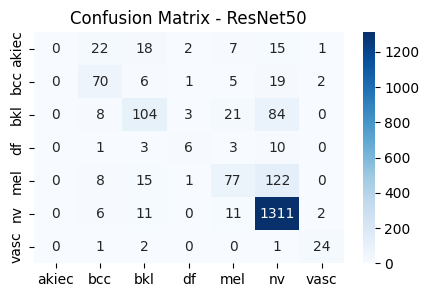

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_loss, val_acc, val_top3 = model.evaluate(val_gen)
print("Val Loss:", val_loss)
print("Val Acc:", val_acc)
print("Val Top-3 Acc:", val_top3)

y_prob = model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix - ResNet50")
plt.show()

model.save("resnet50_final.keras")

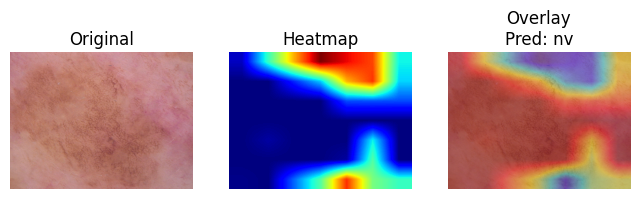

In [28]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

RESNET_LAYER_NAME = "conv5_block3_out"  # last conv layer for ResNet50

def get_gradcam_heatmap(img_array, model, layer_name):

    # Sub-model: input → conv layer output, predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Forward + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)  # gradient of predicted class w.r.t feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    # Weighted sum of feature maps
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap, int(pred_index.numpy())


def show_gradcam_resnet(image_path, model, preprocess_fn, layer_name=RESNET_LAYER_NAME):

    # Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    # Heatmap
    heatmap, pred_idx = get_gradcam_heatmap(img_array, model, layer_name)
    predicted_label = inv_label_map[pred_idx]

    # Read original
    orig = plt.imread(image_path)

    # Resize heatmap to original size
    heatmap_resized = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Color map
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Overlay
    overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

    # Plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1); plt.imshow(orig); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap_resized, cmap='jet'); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay\nPred: {predicted_label}"); plt.axis("off")
    plt.show()


# Show Grad-CAM for 1 random val images
for p in val_df["img_path"].sample(1).tolist():
    show_gradcam_resnet(p, model, resnet_preprocess)

In [32]:
# DenseNet preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

TARGET_SIZE = (224,224)

dense_train_gen, dense_val_gen = get_generators(
    train_df,
    val_df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    preprocess_fn=densenet_preprocess,
    seed=SEED
)

print("DenseNet Train:", dense_train_gen.n, "Val:", dense_val_gen.n)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
DenseNet Train: 8012 Val: 2003


In [30]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, regularizers

def build_densenet121(num_classes, input_shape=(224,224,3), dropout_rate=0.5):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model, base

dense_model, dense_base = build_densenet121(num_classes=len(label_map))
dense_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,569,991 (28.88 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

callbacks_dense_stage1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
    ModelCheckpoint("densenet_stage1_best.h5", save_best_only=True)
]

dense_model.compile(
    optimizer=Adam(1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

history_dense_stage1 = dense_model.fit(
    dense_train_gen,
    validation_data=dense_val_gen,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks_dense_stage1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.5066 - loss: 8.4047 - top_k_categorical_accuracy: 0.7476

251/251 ━━━━━━━━━━━━━━━━━━━━ 228s 770ms/step - accuracy: 0.5071 - loss: 8.3957 - top_k_categorical_accuracy: 0.7478 - val_accuracy: 0.6750 - val_loss: 1.2319 - val_top_k_categorical_accuracy: 0.8587 - learning_rate: 1.0000e-04
Epoch 2/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 620ms/step - accuracy: 0.6801 - loss: 4.4904 - top_k_categorical_accuracy: 0.8502 - val_accuracy: 0.6825 - val_loss: 1.2775 - val_top_k_categorical_accuracy: 0.8962 - learning_rate: 1.0000e-04
Epoch 3/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6946 - loss: 4.1646 - top_k_categorical_accuracy: 0.8799

251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 620ms/step - accuracy: 0.6946 - loss: 4.1644 - top_k_categorical_accuracy: 0.8799 - val_accuracy: 0.6910 - val_loss: 1.2272 - val_top_k_categorical_accuracy: 0.9151 - learning_rate: 1.0000e-04
Epoch 4/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6923 - loss: 4.0310 - top_k_categorical_accuracy: 0.8918

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 633ms/step - accuracy: 0.6923 - loss: 4.0308 - top_k_categorical_accuracy: 0.8919 - val_accuracy: 0.6975 - val_loss: 1.1683 - val_top_k_categorical_accuracy: 0.9191 - learning_rate: 1.0000e-04
Epoch 5/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7013 - loss: 3.8647 - top_k_categorical_accuracy: 0.8987

251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 627ms/step - accuracy: 0.7014 - loss: 3.8647 - top_k_categorical_accuracy: 0.8987 - val_accuracy: 0.7079 - val_loss: 1.0843 - val_top_k_categorical_accuracy: 0.9251 - learning_rate: 1.0000e-04
Epoch 6/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 617ms/step - accuracy: 0.7035 - loss: 3.8066 - top_k_categorical_accuracy: 0.9071 - val_accuracy: 0.7029 - val_loss: 1.1363 - val_top_k_categorical_accuracy: 0.9306 - learning_rate: 1.0000e-04


In [34]:
# Unfreeze last 80 layers of DenseNet
for layer in dense_base.layers[-80:]:
    layer.trainable = True

dense_model.compile(
    optimizer=Adam(1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

callbacks_dense_stage2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2),
    ModelCheckpoint("densenet_finetuned_best.h5", save_best_only=True)
]

history_dense_stage2 = dense_model.fit(
    dense_train_gen,
    validation_data=dense_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_dense_stage2,
    verbose=1
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.7084 - loss: 3.0371 - top_k_categorical_accuracy: 0.9055

251/251 ━━━━━━━━━━━━━━━━━━━━ 244s 771ms/step - accuracy: 0.7084 - loss: 3.0369 - top_k_categorical_accuracy: 0.9055 - val_accuracy: 0.7039 - val_loss: 1.0736 - val_top_k_categorical_accuracy: 0.9216 - learning_rate: 1.0000e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7072 - loss: 2.9114 - top_k_categorical_accuracy: 0.9027

251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 638ms/step - accuracy: 0.7072 - loss: 2.9114 - top_k_categorical_accuracy: 0.9027 - val_accuracy: 0.7069 - val_loss: 1.0687 - val_top_k_categorical_accuracy: 0.9221 - learning_rate: 1.0000e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7127 - loss: 2.8187 - top_k_categorical_accuracy: 0.9046

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 632ms/step - accuracy: 0.7127 - loss: 2.8187 - top_k_categorical_accuracy: 0.9046 - val_accuracy: 0.7129 - val_loss: 1.0503 - val_top_k_categorical_accuracy: 0.9251 - learning_rate: 1.0000e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7146 - loss: 2.7363 - top_k_categorical_accuracy: 0.9108

251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 626ms/step - accuracy: 0.7146 - loss: 2.7364 - top_k_categorical_accuracy: 0.9108 - val_accuracy: 0.7139 - val_loss: 1.0470 - val_top_k_categorical_accuracy: 0.9266 - learning_rate: 1.0000e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7196 - loss: 2.7042 - top_k_categorical_accuracy: 0.9098

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 631ms/step - accuracy: 0.7196 - loss: 2.7042 - top_k_categorical_accuracy: 0.9098 - val_accuracy: 0.7164 - val_loss: 1.0407 - val_top_k_categorical_accuracy: 0.9286 - learning_rate: 1.0000e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 623ms/step - accuracy: 0.7148 - loss: 2.6416 - top_k_categorical_accuracy: 0.9108 - val_accuracy: 0.7184 - val_loss: 1.0455 - val_top_k_categorical_accuracy: 0.9286 - learning_rate: 1.0000e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7215 - loss: 2.6861 - top_k_categorical_accuracy: 0.9175

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 634ms/step - accuracy: 0.7215 - loss: 2.6860 - top_k_categorical_accuracy: 0.9175 - val_accuracy: 0.7214 - val_loss: 1.0184 - val_top_k_categorical_accuracy: 0.9341 - learning_rate: 1.0000e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7213 - loss: 2.6053 - top_k_categorical_accuracy: 0.9100

251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 644ms/step - accuracy: 0.7213 - loss: 2.6054 - top_k_categorical_accuracy: 0.9101 - val_accuracy: 0.7239 - val_loss: 1.0020 - val_top_k_categorical_accuracy: 0.9341 - learning_rate: 1.0000e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.7381 - loss: 2.5851 - top_k_categorical_accuracy: 0.9242

251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 629ms/step - accuracy: 0.7381 - loss: 2.5852 - top_k_categorical_accuracy: 0.9242 - val_accuracy: 0.7264 - val_loss: 0.9993 - val_top_k_categorical_accuracy: 0.9351 - learning_rate: 1.0000e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7252 - loss: 2.5276 - top_k_categorical_accuracy: 0.9227

251/251 ━━━━━━━━━━━━━━━━━━━━ 159s 633ms/step - accuracy: 0.7252 - loss: 2.5277 - top_k_categorical_accuracy: 0.9227 - val_accuracy: 0.7299 - val_loss: 0.9860 - val_top_k_categorical_accuracy: 0.9356 - learning_rate: 1.0000e-05


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.7200 - loss: 1.0077 - top_k_categorical_accuracy: 0.9334
DenseNet Val Loss: 0.9859617948532104
DenseNet Val Accuracy: 0.7299051284790039
DenseNet Val Top-3 Acc: 0.9355965852737427
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.58      0.40      0.47       103
         bkl       0.60      0.23      0.33       220
          df       0.00      0.00      0.00        23
         mel       0.56      0.06      0.11       223
          nv       0.74      1.00      0.85      1341
        vasc       0.76      0.79      0.77        28

    accuracy                           0.73      2003
   macro avg       0.46      0.35      0.36      2003
weighted avg       0.67      0.73      0.65      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


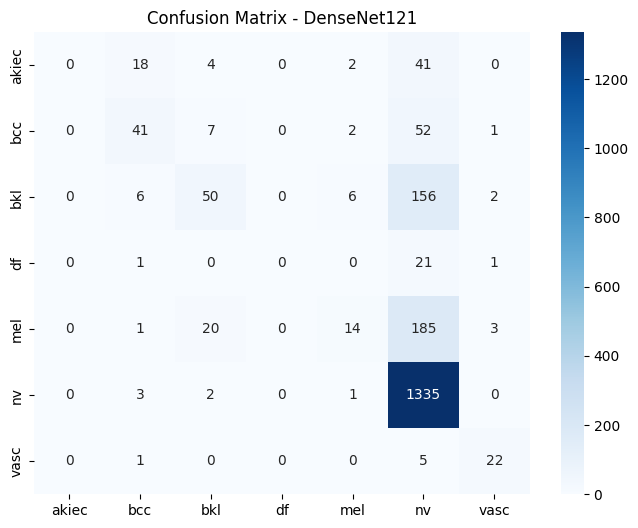

DenseNet saved successfully!


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

val_loss, val_acc, val_top3 = dense_model.evaluate(dense_val_gen)
print("DenseNet Val Loss:", val_loss)
print("DenseNet Val Accuracy:", val_acc)
print("DenseNet Val Top-3 Acc:", val_top3)

y_prob = dense_model.predict(dense_val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = dense_val_gen.classes
labels = list(dense_val_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - DenseNet121")
plt.show()

dense_model.save("/kaggle/working/models/densenet121_final.h5")
print("DenseNet saved successfully!")

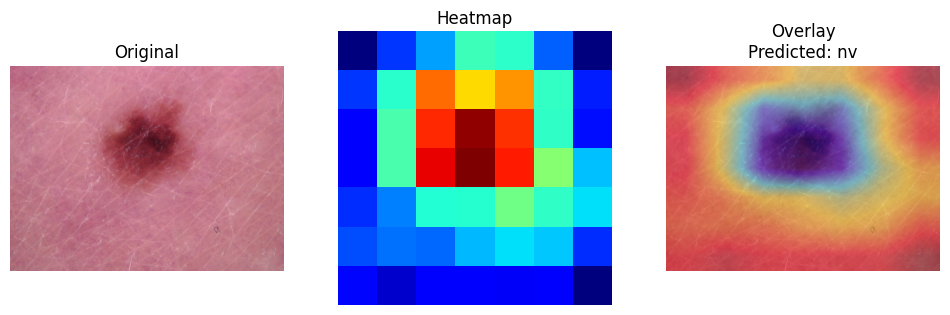

In [37]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Last convolution layer name for DenseNet121
DENSENET_LAYER_NAME = "conv5_block16_concat"


def get_gradcam_heatmap_densenet(img_array, model, layer_name):
    """
    Generates the Grad-CAM heatmap for DenseNet121.
    """

    # Build a model that gives feature maps + predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Forward pass + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    # Weighted sum of feature maps
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap = heatmap / heatmap.max()

    return heatmap, int(pred_index.numpy())



def show_gradcam_densenet(image_path, model, preprocess_fn, layer_name=DENSENET_LAYER_NAME):

    # 1. Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    # 2. Get heatmap
    heatmap, pred_idx = get_gradcam_heatmap_densenet(img_array, model, layer_name)
    predicted_label = inv_label_map[pred_idx]

    # 3. Read original image
    original_img = plt.imread(image_path)

    # Resize heatmap to match original image
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    # 4. Display results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay\nPredicted: {predicted_label}")
    plt.axis("off")

    plt.show()



# 🔥 Show Grad-CAM for 5 random images from validation set
for img_path in val_df["img_path"].sample(1).tolist():
    show_gradcam_densenet(img_path, dense_model, densenet_preprocess)


In [38]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

TARGET_SIZE = (224, 224)   # MobileNetV2 works with 224x224

mobile_train_gen, mobile_val_gen = get_generators(
    train_df,
    val_df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    preprocess_fn=mobilenet_preprocess,
    seed=SEED
)

print("MobileNet Train:", mobile_train_gen.n, "Val:", mobile_val_gen.n)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
MobileNet Train: 8012 Val: 2003


In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers

def build_mobilenet(num_classes, input_shape=(224,224,3), dropout_rate=0.4):
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False   # Stage 1 → freeze base

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model, base

mobile_model, mobile_base = build_mobilenet(len(label_map))
mobile_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,592,839 (9.89 MB)

 Trainable params: 332,295 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_mobile_stage1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, verbose=1),
    ModelCheckpoint("mobilenet_stage1_best.h5", save_best_only=True, monitor='val_loss')
]

mobile_model.compile(
    optimizer=Adam(1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

history_mobile_stage1 = mobile_model.fit(
    mobile_train_gen,
    validation_data=mobile_val_gen,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks_mobile_stage1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.4626 - loss: 10.8338 - top_k_categorical_accuracy: 0.6996

251/251 ━━━━━━━━━━━━━━━━━━━━ 176s 647ms/step - accuracy: 0.4630 - loss: 10.8206 - top_k_categorical_accuracy: 0.6999 - val_accuracy: 0.6850 - val_loss: 1.3120 - val_top_k_categorical_accuracy: 0.8387 - learning_rate: 1.0000e-04
Epoch 2/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 599ms/step - accuracy: 0.6664 - loss: 4.9984 - top_k_categorical_accuracy: 0.8383 - val_accuracy: 0.6960 - val_loss: 1.3167 - val_top_k_categorical_accuracy: 0.8752 - learning_rate: 1.0000e-04
Epoch 3/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.6859 - loss: 4.5717 - top_k_categorical_accuracy: 0.8639

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 596ms/step - accuracy: 0.6860 - loss: 4.5716 - top_k_categorical_accuracy: 0.8640 - val_accuracy: 0.7024 - val_loss: 1.3005 - val_top_k_categorical_accuracy: 0.8837 - learning_rate: 1.0000e-04
Epoch 4/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7056 - loss: 4.2963 - top_k_categorical_accuracy: 0.8828

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 596ms/step - accuracy: 0.7056 - loss: 4.2963 - top_k_categorical_accuracy: 0.8827 - val_accuracy: 0.7079 - val_loss: 1.2562 - val_top_k_categorical_accuracy: 0.8967 - learning_rate: 1.0000e-04
Epoch 5/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7064 - loss: 4.1731 - top_k_categorical_accuracy: 0.8783

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 599ms/step - accuracy: 0.7064 - loss: 4.1731 - top_k_categorical_accuracy: 0.8783 - val_accuracy: 0.7119 - val_loss: 1.2317 - val_top_k_categorical_accuracy: 0.9091 - learning_rate: 1.0000e-04
Epoch 6/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7115 - loss: 4.1102 - top_k_categorical_accuracy: 0.8977

251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 604ms/step - accuracy: 0.7115 - loss: 4.1099 - top_k_categorical_accuracy: 0.8977 - val_accuracy: 0.7144 - val_loss: 1.1857 - val_top_k_categorical_accuracy: 0.9156 - learning_rate: 1.0000e-04


In [41]:
# Unfreeze last 60 layers of MobileNetV2
for layer in mobile_base.layers[-60:]:
    layer.trainable = True

mobile_model.compile(
    optimizer=Adam(1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

callbacks_mobile_stage2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, verbose=1),
    ModelCheckpoint("mobilenet_finetuned_best.h5", save_best_only=True, monitor='val_loss')
]

history_mobile_stage2 = mobile_model.fit(
    mobile_train_gen,
    validation_data=mobile_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_mobile_stage2,
    verbose=1
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6611 - loss: 4.3222 - top_k_categorical_accuracy: 0.8450

251/251 ━━━━━━━━━━━━━━━━━━━━ 195s 665ms/step - accuracy: 0.6612 - loss: 4.3211 - top_k_categorical_accuracy: 0.8451 - val_accuracy: 0.6800 - val_loss: 2.2898 - val_top_k_categorical_accuracy: 0.8882 - learning_rate: 1.0000e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 603ms/step - accuracy: 0.6972 - loss: 3.5009 - top_k_categorical_accuracy: 0.8642 - val_accuracy: 0.6830 - val_loss: 2.3107 - val_top_k_categorical_accuracy: 0.8907 - learning_rate: 1.0000e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7015 - loss: 3.2019 - top_k_categorical_accuracy: 0.8814

251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 616ms/step - accuracy: 0.7015 - loss: 3.2019 - top_k_categorical_accuracy: 0.8814 - val_accuracy: 0.6840 - val_loss: 2.1180 - val_top_k_categorical_accuracy: 0.9011 - learning_rate: 1.0000e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7149 - loss: 3.0487 - top_k_categorical_accuracy: 0.8881

251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 607ms/step - accuracy: 0.7148 - loss: 3.0487 - top_k_categorical_accuracy: 0.8881 - val_accuracy: 0.6895 - val_loss: 1.7944 - val_top_k_categorical_accuracy: 0.9066 - learning_rate: 1.0000e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7195 - loss: 2.9508 - top_k_categorical_accuracy: 0.9013

251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 608ms/step - accuracy: 0.7195 - loss: 2.9508 - top_k_categorical_accuracy: 0.9013 - val_accuracy: 0.7009 - val_loss: 1.5637 - val_top_k_categorical_accuracy: 0.9071 - learning_rate: 1.0000e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.7273 - loss: 2.8095 - top_k_categorical_accuracy: 0.9010

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 597ms/step - accuracy: 0.7273 - loss: 2.8098 - top_k_categorical_accuracy: 0.9010 - val_accuracy: 0.7089 - val_loss: 1.3960 - val_top_k_categorical_accuracy: 0.9141 - learning_rate: 1.0000e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7283 - loss: 2.8296 - top_k_categorical_accuracy: 0.9041

251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 606ms/step - accuracy: 0.7283 - loss: 2.8295 - top_k_categorical_accuracy: 0.9041 - val_accuracy: 0.7099 - val_loss: 1.2972 - val_top_k_categorical_accuracy: 0.9136 - learning_rate: 1.0000e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7300 - loss: 2.8082 - top_k_categorical_accuracy: 0.9092

251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 612ms/step - accuracy: 0.7300 - loss: 2.8079 - top_k_categorical_accuracy: 0.9092 - val_accuracy: 0.7209 - val_loss: 1.1689 - val_top_k_categorical_accuracy: 0.9216 - learning_rate: 1.0000e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7382 - loss: 2.6504 - top_k_categorical_accuracy: 0.9184

251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 623ms/step - accuracy: 0.7381 - loss: 2.6504 - top_k_categorical_accuracy: 0.9184 - val_accuracy: 0.7294 - val_loss: 1.0905 - val_top_k_categorical_accuracy: 0.9216 - learning_rate: 1.0000e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7417 - loss: 2.6396 - top_k_categorical_accuracy: 0.9213

251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 619ms/step - accuracy: 0.7417 - loss: 2.6394 - top_k_categorical_accuracy: 0.9213 - val_accuracy: 0.7369 - val_loss: 1.0528 - val_top_k_categorical_accuracy: 0.9281 - learning_rate: 1.0000e-05


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.7322 - loss: 1.0808 - top_k_categorical_accuracy: 0.9251
MobileNet Val Loss: 1.0528148412704468
MobileNet Val Accuracy: 0.7368946671485901
MobileNet Top-3 Accuracy: 0.9281078577041626
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.63      0.58      0.61       103
         bkl       0.58      0.17      0.26       220
          df       0.00      0.00      0.00        23
         mel       0.56      0.10      0.17       223
          nv       0.75      0.99      0.86      1341
        vasc       0.67      0.86      0.75        28

    accuracy                           0.74      2003
   macro avg       0.46      0.39      0.38      2003
weighted avg       0.67      0.74      0.66      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


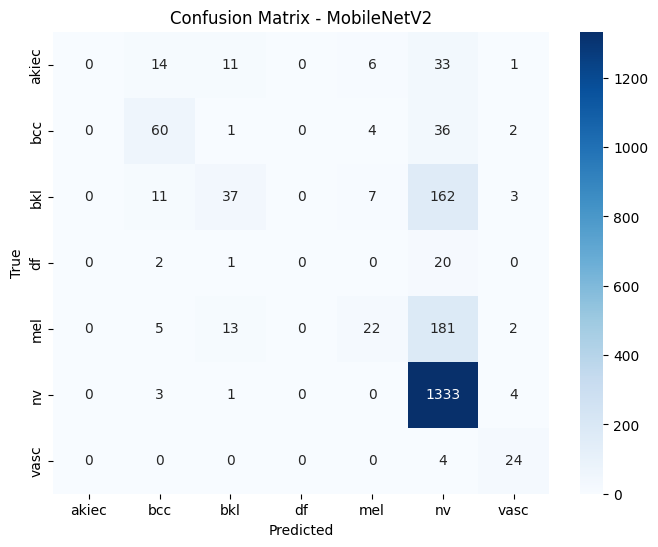

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_loss, val_acc, val_top3 = mobile_model.evaluate(mobile_val_gen)
print("MobileNet Val Loss:", val_loss)
print("MobileNet Val Accuracy:", val_acc)
print("MobileNet Top-3 Accuracy:", val_top3)

y_prob = mobile_model.predict(mobile_val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = mobile_val_gen.classes
labels = list(mobile_val_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save final model
mobile_model.save("/kaggle/working/models/mobilenet_v2_final.h5.keras")

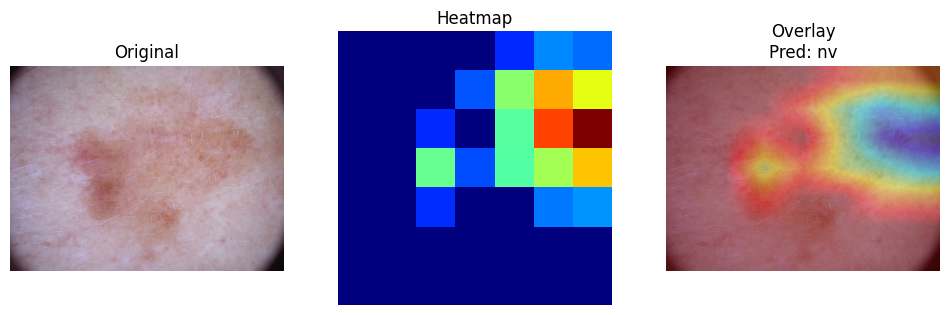

In [45]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

MOBILENET_LAYER_NAME = "block_16_project"

def get_gradcam_heatmap_mobilenet(img_array, model, layer_name):

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap /= heatmap.max()

    return heatmap, int(pred_index.numpy())


def show_gradcam_mobilenet(image_path, model, preprocess_fn, layer_name=MOBILENET_LAYER_NAME):

    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    heatmap, pred_idx = get_gradcam_heatmap_mobilenet(img_array, model, layer_name)
    predicted_label = inv_label_map[pred_idx]

    original = plt.imread(image_path)

    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(original); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay\nPred: {predicted_label}"); plt.axis("off")
    plt.show()


# Show Grad-CAM for 1 random validation samples
for p in val_df["img_path"].sample(1).tolist():
    show_gradcam_mobilenet(p, mobile_model, mobilenet_preprocess)

In [56]:
# EfficientNetB0 generators
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

TARGET_SIZE = (224, 224)
# BATCH_SIZE, train_df, val_df, SEED already defined

train_gen, val_gen = get_generators(
    train_df,
    val_df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    preprocess_fn=eff_preprocess,
    seed=SEED
)

print("Train samples:", train_gen.n, "Val samples:", val_gen.n)
print("Class indices:", train_gen.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Train samples: 8012 Val samples: 2003
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [57]:
# Build EfficientNetB0 model (returns model and base)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers

def build_efficientnet_b0(num_classes, input_shape=(224,224,3), dropout_rate=0.4):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model, base

num_classes = len(label_map)
eff_model, eff_base = build_efficientnet_b0(num_classes=num_classes, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], IMG_CHANNELS))
eff_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,384,426 (16.73 MB)

 Trainable params: 332,295 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [58]:
# Stage 1 training (feature extraction)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import time, json

callbacks_eff_stage1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(os.path.join(OUTPUT_DIR, "efficientnetb0_stage1_best.h5"), save_best_only=True, monitor='val_loss')
]

eff_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top-3-acc')]
)

start = time.time()
history_eff_stage1 = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks_eff_stage1,
    verbose=1
)
print("Stage1 time (s):", time.time() - start)

# save history
with open(os.path.join(OUTPUT_DIR, "history_eff_stage1.json"), "w") as f:
    json.dump(history_eff_stage1.history, f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4598 - loss: 10.9685 - top-3-acc: 0.6997

251/251 ━━━━━━━━━━━━━━━━━━━━ 193s 664ms/step - accuracy: 0.4603 - loss: 10.9547 - top-3-acc: 0.7000 - val_accuracy: 0.6725 - val_loss: 1.2446 - val_top-3-acc: 0.8427 - learning_rate: 1.0000e-04
Epoch 2/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 585ms/step - accuracy: 0.6719 - loss: 5.1190 - top-3-acc: 0.8397 - val_accuracy: 0.6810 - val_loss: 1.4009 - val_top-3-acc: 0.8782 - learning_rate: 1.0000e-04
Epoch 3/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6813 - loss: 4.6402 - top-3-acc: 0.8594
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 589ms/step - accuracy: 0.6813 - loss: 4.6401 - top-3-acc: 0.8594 - val_accuracy: 0.6905 - val_loss: 1.3426 - val_top-3-acc: 0.8957 - learning_rate: 1.0000e-04
Epoch 4/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 584ms/step - accuracy: 0.6977 - loss: 4.3669 - top-3-acc: 0.8813 - val_accuracy: 0.6910 - val_loss: 1.3082 - val_top-3-acc: 0.8982 - learning_rate: 3.0000e-05
Epoch 5/6
251/251 ━━━━━

In [59]:
# Stage 2 fine-tuning: unfreeze top N layers
N = 100   # you can adjust (smaller if OOM)
for layer in eff_base.layers[-N:]:
    layer.trainable = True

eff_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.02),
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top-3-acc')]
)

callbacks_eff_stage2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint(os.path.join(OUTPUT_DIR, "efficientnetb0_finetuned_best.h5"), save_best_only=True, monitor='val_loss')
]

start = time.time()
history_eff_stage2 = eff_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_eff_stage2,
    verbose=1
)
print("Stage2 time (s):", time.time() - start)

# combine and save histories
hist_combined = {}
for k,v in {**history_eff_stage1.history, **history_eff_stage2.history}.items():
    hist_combined[k] = v
with open(os.path.join(OUTPUT_DIR, "history_eff_combined.json"), "w") as f:
    json.dump(hist_combined, f)

Epoch 1/10


E0000 00:00:1763380808.558780     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763380808.702371     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763380809.045166     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763380809.185651     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 71/251 ━━━━━━━━━━━━━━━━━━━━ 1:35 529ms/step - accuracy: 0.5652 - loss: 6.6550 - top-3-acc: 0.8028

E0000 00:00:1763380863.091010     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763380863.228707     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5867 - loss: 6.2440 - top-3-acc: 0.8073

251/251 ━━━━━━━━━━━━━━━━━━━━ 225s 703ms/step - accuracy: 0.5868 - loss: 6.2421 - top-3-acc: 0.8073 - val_accuracy: 0.6805 - val_loss: 1.4708 - val_top-3-acc: 0.8178 - learning_rate: 1.0000e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.6417 - loss: 4.7931 - top-3-acc: 0.8149

251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 590ms/step - accuracy: 0.6418 - loss: 4.7924 - top-3-acc: 0.8149 - val_accuracy: 0.6850 - val_loss: 1.4706 - val_top-3-acc: 0.8283 - learning_rate: 1.0000e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.6714 - loss: 4.3456 - top-3-acc: 0.8344

251/251 ━━━━━━━━━━━━━━━━━━━━ 152s 604ms/step - accuracy: 0.6714 - loss: 4.3452 - top-3-acc: 0.8344 - val_accuracy: 0.6880 - val_loss: 1.4549 - val_top-3-acc: 0.8387 - learning_rate: 1.0000e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6808 - loss: 4.0312 - top-3-acc: 0.8469

251/251 ━━━━━━━━━━━━━━━━━━━━ 151s 601ms/step - accuracy: 0.6808 - loss: 4.0307 - top-3-acc: 0.8469 - val_accuracy: 0.6885 - val_loss: 1.4274 - val_top-3-acc: 0.8537 - learning_rate: 1.0000e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6854 - loss: 3.6238 - top-3-acc: 0.8622

251/251 ━━━━━━━━━━━━━━━━━━━━ 147s 587ms/step - accuracy: 0.6854 - loss: 3.6239 - top-3-acc: 0.8622 - val_accuracy: 0.6940 - val_loss: 1.3864 - val_top-3-acc: 0.8647 - learning_rate: 1.0000e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6916 - loss: 3.5828 - top-3-acc: 0.8619

251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 589ms/step - accuracy: 0.6916 - loss: 3.5826 - top-3-acc: 0.8619 - val_accuracy: 0.6980 - val_loss: 1.3373 - val_top-3-acc: 0.8742 - learning_rate: 1.0000e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7092 - loss: 3.3884 - top-3-acc: 0.8749

251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 594ms/step - accuracy: 0.7091 - loss: 3.3886 - top-3-acc: 0.8748 - val_accuracy: 0.7014 - val_loss: 1.3093 - val_top-3-acc: 0.8797 - learning_rate: 1.0000e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.7030 - loss: 3.4090 - top-3-acc: 0.8770

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 596ms/step - accuracy: 0.7030 - loss: 3.4086 - top-3-acc: 0.8770 - val_accuracy: 0.7039 - val_loss: 1.2741 - val_top-3-acc: 0.8867 - learning_rate: 1.0000e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7003 - loss: 3.2773 - top-3-acc: 0.8820

251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 590ms/step - accuracy: 0.7003 - loss: 3.2773 - top-3-acc: 0.8820 - val_accuracy: 0.7084 - val_loss: 1.2286 - val_top-3-acc: 0.8907 - learning_rate: 1.0000e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7147 - loss: 3.1821 - top-3-acc: 0.8935

251/251 ━━━━━━━━━━━━━━━━━━━━ 150s 597ms/step - accuracy: 0.7147 - loss: 3.1818 - top-3-acc: 0.8935 - val_accuracy: 0.7134 - val_loss: 1.2127 - val_top-3-acc: 0.9016 - learning_rate: 1.0000e-05
Stage2 time (s): 1569.2992141246796


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6995 - loss: 1.2162 - top-3-acc: 0.8987
EfficientNetB0 - Val loss: 1.212667465209961 Val acc: 0.713429868221283 Val top-3: 0.9016475081443787
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.40      0.55      0.47       103
         bkl       0.47      0.07      0.13       220
          df       0.00      0.00      0.00        23
         mel       0.42      0.04      0.07       223
          nv       0.75      0.99      0.85      1341
        vasc       0.61      0.71      0.66        28

    accuracy                           0.71      2003
   macro avg       0.38      0.34      0.31      2003
weighted avg       0.63      0.71      0.62      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


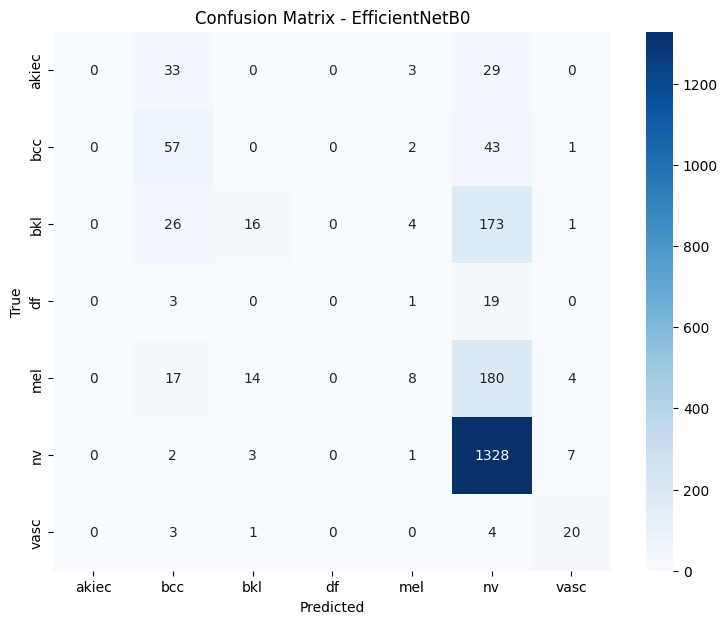

Saved EfficientNetB0 to: /kaggle/working/models/efficientnetb0_final.h5
Appended results to: /kaggle/working/models/model_comparison.csv


In [60]:
# Evaluate EfficientNetB0 and save results
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

val_loss, val_acc, val_top3 = eff_model.evaluate(val_gen, verbose=1)
print("EfficientNetB0 - Val loss:", val_loss, "Val acc:", val_acc, "Val top-3:", val_top3)

# Predictions
y_prob = eff_model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

# Save final model
eff_model.save(os.path.join(OUTPUT_DIR, "efficientnetb0_final.h5"))
print("Saved EfficientNetB0 to:", os.path.join(OUTPUT_DIR, "efficientnetb0_final.h5"))

# Append to model_comparison.csv
res_row = {
    "model": "efficientnetb0",
    "val_loss": float(val_loss),
    "val_acc": float(val_acc),
    "val_top3": float(val_top3),
    "train_samples": int(train_gen.n),
    "val_samples": int(val_gen.n)
}
results_csv = os.path.join(OUTPUT_DIR, "model_comparison.csv")
if os.path.exists(results_csv):
    df_results = pd.read_csv(results_csv)
    df_results = df_results.append(res_row, ignore_index=True)
else:
    df_results = pd.DataFrame([res_row])
df_results.to_csv(results_csv, index=False)
print("Appended results to:", results_csv)

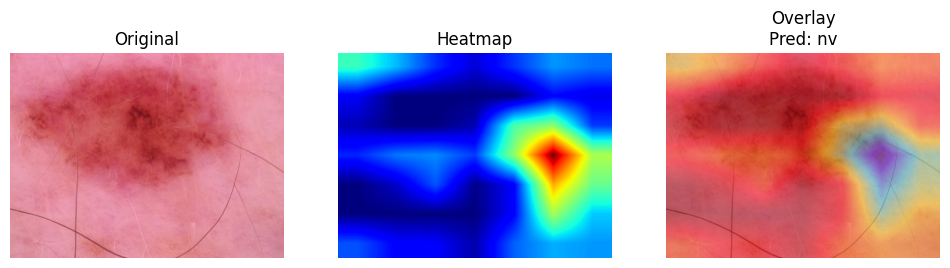

In [61]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

EFF_LAYER_NAME = "top_conv"   # last conv layer in EfficientNetB0


def get_gradcam_heatmap_efficientnet(img_array, model, layer_name):
    # Submodel: input → last conv layer output & predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(layer_name).output,
            model.output
        ]
    )

    # Forward + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Feature maps
    conv_outputs = conv_outputs[0]

    # Weighted sum
    heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # Normalize heatmap (convert to numpy)
    heatmap = heatmap.numpy()
    heatmap = np.maximum(heatmap, 0)

    if heatmap.max() != 0:
        heatmap /= heatmap.max()

    return heatmap, int(pred_index.numpy())


def show_gradcam_efficientnet(image_path, model, preprocess_fn, layer_name=EFF_LAYER_NAME):

    # Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=TARGET_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    # Generate heatmap
    heatmap, pred_idx = get_gradcam_heatmap_efficientnet(img_array, model, layer_name)
    predicted_label = inv_label_map[pred_idx]

    # Load original image
    original = plt.imread(image_path)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Colorize heatmap
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Overlay
    overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(original); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(heatmap_resized, cmap='jet'); plt.title("Heatmap"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title(f"Overlay\nPred: {predicted_label}"); plt.axis("off")
    plt.show()


# Test on 1 random validation images
for p in val_df['img_path'].sample(1):
    show_gradcam_efficientnet(p, eff_model, eff_preprocess)

In [46]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

TARGET_SIZE = (299, 299)   # Required for InceptionV3

inc_train_gen, inc_val_gen = get_generators(
    train_df,
    val_df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    preprocess_fn=inception_preprocess,
    seed=SEED
)

print("InceptionV3 Train:", inc_train_gen.n, "Val:", inc_val_gen.n)
print("Class indices:", inc_train_gen.class_indices)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
InceptionV3 Train: 8012 Val: 2003
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [47]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, regularizers

def build_inceptionv3(num_classes, input_shape=(299,299,3), dropout_rate=0.4):
    base = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base.input, outputs=out)
    return model, base

inception_model, inception_base = build_inceptionv3(len(label_map), input_shape=(299,299,3))
inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,337,319 (85.21 MB)

 Trainable params: 530,439 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [48]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_inc_stage1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint("inceptionv3_stage1_best.h5", save_best_only=True, monitor='val_loss')
]

inception_model.compile(
    optimizer=Adam(1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

history_inc_stage1 = inception_model.fit(
    inc_train_gen,
    validation_data=inc_val_gen,
    epochs=6,
    class_weight=class_weights,
    callbacks=callbacks_inc_stage1,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.4728 - loss: 10.1947 - top_k_categorical_accuracy: 0.7165

251/251 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.4733 - loss: 10.1830 - top_k_categorical_accuracy: 0.7168 - val_accuracy: 0.6800 - val_loss: 1.2219 - val_top_k_categorical_accuracy: 0.8512 - learning_rate: 1.0000e-04
Epoch 2/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 238s 948ms/step - accuracy: 0.6729 - loss: 5.0710 - top_k_categorical_accuracy: 0.8373 - val_accuracy: 0.6925 - val_loss: 1.3488 - val_top_k_categorical_accuracy: 0.8742 - learning_rate: 1.0000e-04
Epoch 3/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.6890 - loss: 4.7348 - top_k_categorical_accuracy: 0.8671
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
251/251 ━━━━━━━━━━━━━━━━━━━━ 239s 954ms/step - accuracy: 0.6890 - loss: 4.7343 - top_k_categorical_accuracy: 0.8671 - val_accuracy: 0.6980 - val_loss: 1.3266 - val_top_k_categorical_accuracy: 0.8832 - learning_rate: 1.0000e-04
Epoch 4/6
251/251 ━━━━━━━━━━━━━━━━━━━━ 239s 951ms/step - accuracy: 0.6913 - loss: 4.3760 - top_k_categorical_a

In [49]:
# Unfreeze last 120 layers of InceptionV3
for layer in inception_base.layers[-120:]:
    layer.trainable = True

inception_model.compile(
    optimizer=Adam(1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.02),
    metrics=["accuracy", TopKCategoricalAccuracy(k=3)]
)

callbacks_inc_stage2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint("inceptionv3_finetuned_best.h5", save_best_only=True, monitor='val_loss')
]

history_inc_stage2 = inception_model.fit(
    inc_train_gen,
    validation_data=inc_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_inc_stage2,
    verbose=1
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.6276 - loss: 5.3681 - top_k_categorical_accuracy: 0.8088

251/251 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.6276 - loss: 5.3659 - top_k_categorical_accuracy: 0.8089 - val_accuracy: 0.6770 - val_loss: 1.3142 - val_top_k_categorical_accuracy: 0.8522 - learning_rate: 1.0000e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.6737 - loss: 4.0408 - top_k_categorical_accuracy: 0.8357

251/251 ━━━━━━━━━━━━━━━━━━━━ 243s 966ms/step - accuracy: 0.6737 - loss: 4.0402 - top_k_categorical_accuracy: 0.8357 - val_accuracy: 0.6915 - val_loss: 1.2781 - val_top_k_categorical_accuracy: 0.8622 - learning_rate: 1.0000e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6998 - loss: 3.5067 - top_k_categorical_accuracy: 0.8606

251/251 ━━━━━━━━━━━━━━━━━━━━ 242s 964ms/step - accuracy: 0.6998 - loss: 3.5068 - top_k_categorical_accuracy: 0.8606 - val_accuracy: 0.6945 - val_loss: 1.2742 - val_top_k_categorical_accuracy: 0.8797 - learning_rate: 1.0000e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.6934 - loss: 3.4822 - top_k_categorical_accuracy: 0.8727

251/251 ━━━━━━━━━━━━━━━━━━━━ 244s 971ms/step - accuracy: 0.6934 - loss: 3.4817 - top_k_categorical_accuracy: 0.8727 - val_accuracy: 0.7079 - val_loss: 1.1825 - val_top_k_categorical_accuracy: 0.8977 - learning_rate: 1.0000e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.7179 - loss: 3.1071 - top_k_categorical_accuracy: 0.8866

251/251 ━━━━━━━━━━━━━━━━━━━━ 244s 973ms/step - accuracy: 0.7180 - loss: 3.1070 - top_k_categorical_accuracy: 0.8866 - val_accuracy: 0.7149 - val_loss: 1.1391 - val_top_k_categorical_accuracy: 0.9071 - learning_rate: 1.0000e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 241s 958ms/step - accuracy: 0.7266 - loss: 3.0232 - top_k_categorical_accuracy: 0.8954 - val_accuracy: 0.7169 - val_loss: 1.1623 - val_top_k_categorical_accuracy: 0.9151 - learning_rate: 1.0000e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.7262 - loss: 2.9188 - top_k_categorical_accuracy: 0.9056

251/251 ━━━━━━━━━━━━━━━━━━━━ 238s 948ms/step - accuracy: 0.7262 - loss: 2.9187 - top_k_categorical_accuracy: 0.9056 - val_accuracy: 0.7269 - val_loss: 1.0887 - val_top_k_categorical_accuracy: 0.9176 - learning_rate: 1.0000e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.7493 - loss: 2.7000 - top_k_categorical_accuracy: 0.9093

251/251 ━━━━━━━━━━━━━━━━━━━━ 245s 975ms/step - accuracy: 0.7492 - loss: 2.7000 - top_k_categorical_accuracy: 0.9093 - val_accuracy: 0.7359 - val_loss: 1.0633 - val_top_k_categorical_accuracy: 0.9256 - learning_rate: 1.0000e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.7588 - loss: 2.6349 - top_k_categorical_accuracy: 0.9193

251/251 ━━━━━━━━━━━━━━━━━━━━ 237s 944ms/step - accuracy: 0.7588 - loss: 2.6349 - top_k_categorical_accuracy: 0.9193 - val_accuracy: 0.7414 - val_loss: 1.0481 - val_top_k_categorical_accuracy: 0.9301 - learning_rate: 1.0000e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.7532 - loss: 2.5723 - top_k_categorical_accuracy: 0.9146

251/251 ━━━━━━━━━━━━━━━━━━━━ 244s 973ms/step - accuracy: 0.7532 - loss: 2.5722 - top_k_categorical_accuracy: 0.9146 - val_accuracy: 0.7429 - val_loss: 1.0479 - val_top_k_categorical_accuracy: 0.9281 - learning_rate: 1.0000e-05


63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - accuracy: 0.7375 - loss: 1.0875 - top_k_categorical_accuracy: 0.9245
InceptionV3 Val Loss: 1.0478532314300537
InceptionV3 Val Accuracy: 0.7428856492042542
InceptionV3 Top-3 Accuracy: 0.9281078577041626
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.55      0.48      0.51       103
         bkl       0.51      0.27      0.36       220
          df       1.00      0.13      0.23        23
         mel       0.65      0.12      0.20       223
          nv       0.77      0.99      0.87      1341
        vasc       0.77      0.61      0.68        28

    accuracy                           0.74      2003
   macro avg       0.61      0.37      0.41      2003
weighted avg       0.69      0.74      0.68      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


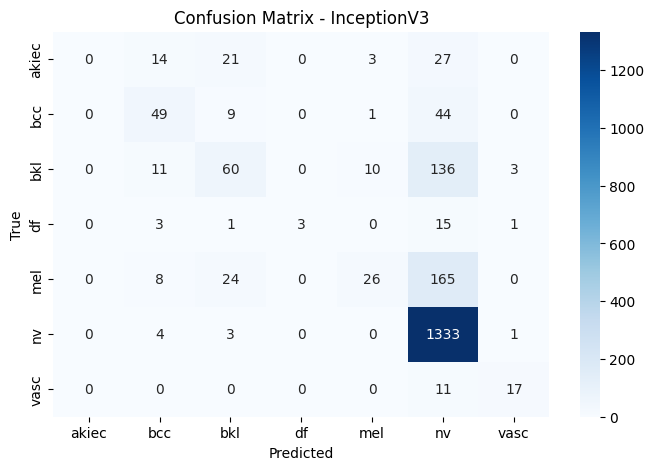

Saved InceptionV3 model


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_loss, val_acc, val_top3 = inception_model.evaluate(inc_val_gen)
print("InceptionV3 Val Loss:", val_loss)
print("InceptionV3 Val Accuracy:", val_acc)
print("InceptionV3 Top-3 Accuracy:", val_top3)

y_prob = inception_model.predict(inc_val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = inc_val_gen.classes
labels = list(inc_val_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - InceptionV3')
plt.show()

inception_model.save("/kaggle/working/models/inceptionv3_final.h5.keras")
print("Saved InceptionV3 model")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_771']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


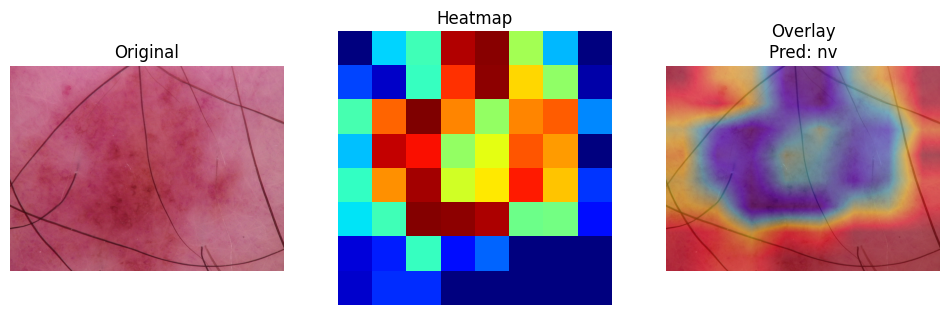

In [52]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

INCEPTION_LAYER_NAME = "mixed10"

def get_gradcam_heatmap_inception(img_array, model, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() != 0:
        heatmap /= heatmap.max()

    return heatmap, int(pred_index.numpy())


def show_gradcam_inception(image_path, model, preprocess_fn, layer_name=INCEPTION_LAYER_NAME):

    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299,299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    heatmap, pred_idx = get_gradcam_heatmap_inception(img_array, model, layer_name)
    predicted_label = inv_label_map[pred_idx]

    original = plt.imread(image_path)

    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(original); plt.axis("off"); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.axis("off"); plt.title("Heatmap")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title(f"Overlay\nPred: {predicted_label}")
    plt.show()

# Show Grad-CAM for 1 images
for p in val_df["img_path"].sample(1).tolist():
    show_gradcam_inception(p, inception_model, inception_preprocess)

In [63]:
from tensorflow.keras.models import load_model

resnet_model = load_model("/kaggle/working/resnet50_final.keras")
dense_model = load_model("/kaggle/working/models/densenet121_final.h5")
mobile_model = load_model("/kaggle/working/models/mobilenet_v2_final.h5.keras")
efficientnet_model = load_model("/kaggle/working/models/efficientnetb0_final.h5")
inception_model = load_model("/kaggle/working/models/inceptionv3_final.h5.keras")

print("All saved models loaded successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 68 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 70 variables whereas the saved optimizer has 138 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


All saved models loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 77 variables whereas the saved optimizer has 152 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
import os

print("Files in /kaggle/working:")
print(os.listdir("/kaggle/working"))

print("\nFiles in /kaggle/working/models:")
if os.path.exists("/kaggle/working/models"):
    print(os.listdir("/kaggle/working/models"))
else:
    print("No models folder found")

Files in /kaggle/working:
['.virtual_documents', 'densenet_finetuned_best.h5', 'densenet_stage1_best.h5', 'resnet50_final.keras', 'resnet50_stage1_best.h5', 'val_df.csv', 'models', 'train_df.csv', 'resnet50_finetuned_best.h5', 'inceptionv3_finetuned_best.h5', 'inceptionv3_stage1_best.h5', 'mobilenet_stage1_best.h5', 'mobilenet_finetuned_best.h5']

Files in /kaggle/working/models:
['model_comparison.csv', 'resnet50_final.h5', 'mobilenet_v2_final.h5', 'inceptionv3_final.h5.keras', 'inceptionv3_final.h5', 'history_eff_stage1.json', 'densenet121_final.h5', 'history_eff_combined.json', 'mobilenet_v2_final.h5.keras', 'efficientnetb0_final.h5', 'efficientnetb0_stage1_best.h5', 'efficientnetb0_finetuned_best.h5']


In [64]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [66]:
model_info = {
    "ResNet50": {
        "path": "/kaggle/working/models/resnet50_final.h5",
        "size": (224,224),
        "preprocess": resnet_preprocess
    },
    "DenseNet121": {
        "path": "/kaggle/working/models/densenet121_final.h5",
        "size": (224,224),
        "preprocess": densenet_preprocess
    },
    "MobileNetV2": {
        "path": "/kaggle/working/models/mobilenet_v2_final.h5",
        "size": (224,224),
        "preprocess": mobilenet_preprocess
    },
    "EfficientNetB0": {
        "path": "/kaggle/working/models/efficientnetb0_final.h5",
        "size": (224,224),
        "preprocess": eff_preprocess
    },
    "InceptionV3": {
        "path": "/kaggle/working/models/inceptionv3_final.h5",
        "size": (299,299),
        "preprocess": inception_preprocess
    }
}

In [ ]:
def get_val_gen(size, preprocess_fn):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    gen = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="img_path",
        y_col="dx",
        target_size=size,
        batch_size=32,
        shuffle=False,
        class_mode="categorical"
    )
    return gen


In [68]:
models_to_compare = {
    "ResNet50": "/kaggle/working/models/resnet50_final.h5",
    "DenseNet121": "/kaggle/working/models/densenet121_final.h5",
    "MobileNetV2": "/kaggle/working/models/mobilenet_v2_final.h5",
    "EfficientNetB0": "/kaggle/working/models/efficientnetb0_final.h5",
    "InceptionV3": "/kaggle/working/models/inceptionv3_final.h5",
}

In [69]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.densenet import preprocess_input as dense_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre

model_preprocess = {
    "ResNet50": (resnet_pre, (224,224)),
    "DenseNet121": (dense_pre, (224,224)),
    "MobileNetV2": (mobilenet_pre, (224,224)),
    "EfficientNetB0": (eff_pre, (224,224)),
    "InceptionV3": (inc_pre, (299,299)),
}

In [70]:
def get_val_gen(size, preprocess_fn):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    return datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="img_path",
        y_col="dx",
        target_size=size,
        class_mode="categorical",
        shuffle=False,
        batch_size=32
    )

In [71]:
from tensorflow.keras.models import load_model
import pandas as pd

results = []

for name, path in models_to_compare.items():
    print(f"\nEvaluating {name}...")

    # load that model
    model = load_model(path)

    # get preprocess + size
    preprocess_fn, size = model_preprocess[name]

    # generator
    val_gen_local = get_val_gen(size, preprocess_fn)

    # evaluation
    loss, acc, top3 = model.evaluate(val_gen_local, verbose=0)

    results.append({
        "Model": name,
        "Val_Accuracy": acc,
        "Top3_Accuracy": top3,
        "Val_Loss": loss
    })

df_compare = pd.DataFrame(results)
df_compare


Evaluating ResNet50...


Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating DenseNet121...


Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating MobileNetV2...


Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating EfficientNetB0...


Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating InceptionV3...


Found 2003 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model  Val_Accuracy  Top3_Accuracy  Val_Loss
0        ResNet50      0.794808       0.953570  0.859211
1     DenseNet121      0.729905       0.935597  0.985962
2     MobileNetV2      0.736895       0.928108  1.052815
3  EfficientNetB0      0.713430       0.901648  1.212667
4     InceptionV3      0.742886       0.928108  1.047853

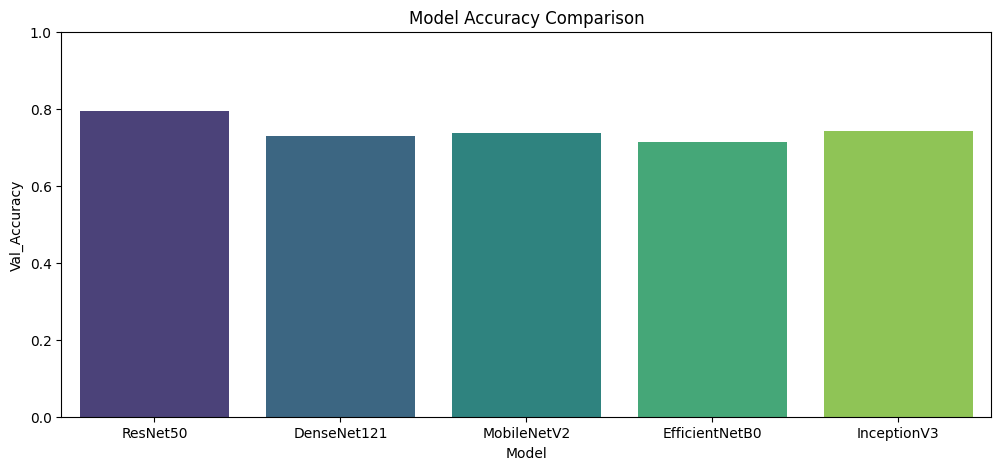

In [72]:
plt.figure(figsize=(12,5))
sns.barplot(data=df_compare, x="Model", y="Val_Accuracy", palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()